In [1]:
import xml.etree.ElementTree as ET
import bz2
# Read data into xml etree
with bz2.open('./data/gp2d.xml.bz2', 'rb') as bf:
    tree = ET.parse(bf)
root = tree.getroot()

## Can we predict missing word using only the words around it?
  - First step is to get a descent prediction of words.
  - Compare LSTM with Bidirectional LSTM performance.


In [2]:
from collections import defaultdict

# Initialize empty counts
sents_per_text_tag = defaultdict(int)
# Count how many tokens per sentence
token_count = defaultdict(int)
all_sents_pos = []
all_sents_words = []
all_sents_ids = []
for text in root.findall('text'):    
    # Join multiple sentences from same text issue
    # curr_sent = []    
    for i, sent in enumerate(text.findall('sentence')):
        sent_pos = []
        # Only the word
        sent_word = []
        for j,w in enumerate(sent.findall('w')):
            sent_pos.append(w.get('pos'))            
            sent_word.append(w.text)
        token_count[j+1] += 1
        # For now keep these sentences from same text as different sentences
        # Change this to curr_sent.append(sent_pos); and then at the end all_sents.append(curr_sents
        # Or something like this.
        all_sents_pos.append(sent_pos)
        all_sents_words.append(sent_word)
        all_sents_ids.append(sent.get('id'))
    # Add one to the max index
    sents_per_text_tag[i+1] += 1
print("Found sentence count:", len(all_sents_words))

Found sentence count: 82206


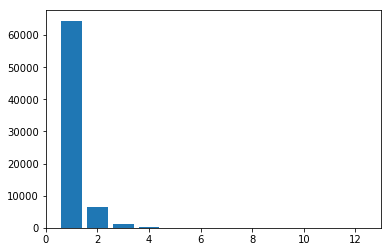

In [3]:
import matplotlib.pyplot as plt

plt.bar(list(sents_per_text_tag.keys()), sents_per_text_tag.values())
plt.show()

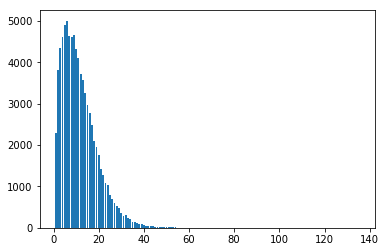

In [4]:
plt.bar(list(token_count.keys()), token_count.values())
plt.show()

In [5]:
all_sents_words[5]

['Dock', 'ingen', 'militant', 'sådan', '.']

In [6]:
from keras.preprocessing.text import Tokenizer

max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts([" ".join(s) for s in all_sents_words])

word_lookup = {v: k for k, v in tokenizer.word_index.items()} 

Using TensorFlow backend.


In [84]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import itertools
import numpy as np

def create_training_example(sentence, pos_tags, sent_id, cloze_pos=['NN', 'VB', 'JJ'], window_size=3):
    for i, word in enumerate(sentence):   
        if pos_tags[i] in cloze_pos:
            before = sentence[max(i-window_size, 0):i]
            after = sentence[i+1:i+window_size]
            seqs = tokenizer.texts_to_sequences([before, after, [word]])
            # Skip words that are out of vocabulary
            # We don't want OOV words as any of the predicting values
            # 1 is OOV index
            if 1 in itertools.chain(*seqs):
                continue
            seqs[0] = pad_sequences([seqs[0]], maxlen=window_size, padding='pre', truncating='pre')[0]
            seqs[1] = pad_sequences([seqs[1]], maxlen=window_size, padding='post', truncating='post')[0]
            
            yield sent_id, seqs[0], seqs[1], seqs[2][0]

In [85]:
pd.DataFrame(create_training_example(all_sents_words[50], all_sents_pos[50], all_sents_ids[50]))

,0,1,2,3
0,cf41a6be-cf4dfe37,"[0, 0, 0]","[54, 177, 0]",7547
1,cf41a6be-cf4dfe37,"[0, 0, 7547]","[177, 32, 0]",54
2,cf41a6be-cf4dfe37,"[54, 177, 32]","[14, 287, 0]",3282


In [91]:
from keras.utils import to_categorical

X_ids = []
X_before = []
X_after = []
y = []
for words, w_pos, s_id in zip(all_sents_words, all_sents_pos, all_sents_ids):
    for ex_id, before, after, w in create_training_example(words, w_pos, s_id):
        X_ids.append(ex_id)
        X_before.append(before)
        X_after.append(after)
        y.append(w)

X_ids = np.array(X_ids)
X_before = np.array(X_before)
X_after = np.array(X_after)
y_cat = to_categorical(y, num_classes = max_words + 1)

In [87]:
data = []
for words, w_pos, s_id in zip(all_sents_words, all_sents_pos, all_sents_ids):
    data += create_training_example(words, w_pos, s_id)
df = pd.DataFrame(data)

In [83]:
df

,0,1,2,3
0,cf400b1b-cf426bef,"[0, 0, 0]","[0, 0, 0]",[1052]
1,cf42a28e-cf4fc0d1,"[16, 3, 49]","[29, 9476, 0]",[408]
2,cf42a28e-cf4fc0d1,"[7, 17, 93]","[234, 7, 0]",[7542]
3,cf45a303-cf46ffa3,"[0, 19, 43]","[5795, 1945, 0]",[48]
4,cf45a303-cf46ffa3,"[19, 43, 48]","[1945, 13, 0]",[5795]
5,cf45a303-cf46ffa3,"[43, 48, 5795]","[13, 11, 0]",[1945]
6,cf45a303-cf46ffa3,"[11, 276, 26]","[4, 494, 0]",[48]
7,cf45a303-cf46ffa3,"[26, 48, 4]","[27, 5, 0]",[494]
8,cf46cc6f-cf4ad09b,"[0, 0, 67]","[108, 2373, 0]",[48]
9,cf46cc6f-cf4ad09b,"[67, 48, 108]","[5, 92, 0]",[2373]


In [92]:
from keras.models import Model
from keras.layers import Dense, LSTM, Embedding, Input, Dropout, concatenate


vocab_size = max_words + 1
embed_size = 100

before_length = X_before.shape[1]
after_length = X_after.shape[1]
input_length = before_length + after_length
cats_length = y_cat.shape[1]

## Model 1
before_input = Input(shape=(before_length,), name="before_input")
after_input = Input(shape=(after_length,), name="after_input")

inputs = concatenate([before_input, after_input])

embed = Embedding(vocab_size, embed_size, input_length=input_length)(inputs)
lstm = LSTM(50, dropout=0.1)(embed)

# Word prediction softmax
word_pred = Dense(vocab_size, activation='softmax', name='word_prediction')(lstm)

# This creates a model that includes
# the Input layer and two Dense layers outputs
model = Model(inputs=[before_input, after_input], outputs=word_pred)

model.compile(optimizer='adam',
                loss={
                    'word_prediction': 'categorical_crossentropy'
                },
                metrics=['accuracy'])

model.summary()

model.fit([X_before, X_after], y_cat, batch_size=1024)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
before_input (InputLayer)       (None, 3)            0                                            
__________________________________________________________________________________________________
after_input (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 6)            0           before_input[0][0]               
                                                                 after_input[0][0]                
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 6, 100)       1000100     concatenate_6[0][0]              
__________

## What sentences are good example sentences?

  - Does length of sentence make a difference?
  - Does the source make a difference?
    - Compare the accuracy of the same words in each dataset
 

### Tokenizer and to_categorical behavior test

Test below to show how tokenizer works with `oov_token` and converting `to_categorical`.

In [12]:
from keras.utils import to_categorical

num_words = 6
test = Tokenizer(num_words=num_words, oov_token='UNK')
test.fit_on_texts(["Hello my name is Stefan"])
word_lookup = {v: k for k, v in test.word_index.items()} 
seq = test.texts_to_sequences(["Hello my name is Stefan"])
print(seq)
print([word_lookup[w] for w in seq[0]])

to_categorical([1,2,3,4,5,6], num_classes=num_words+1)

[[2, 3, 4, 5, 1]]
['hello', 'my', 'name', 'is', 'UNK']


array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [13]:
import pandas as pd
import csv
stats = pd.read_csv('./data/stats_GP2D.txt', header = None, delim_whitespace=True, quoting=csv.QUOTE_NONE, encoding='utf-8', )

In [14]:
# https://spraakbanken.gu.se/swe/info
# https://spraakbanken.gu.se/korp/markup/msdtags.html
stats.columns = ['ordform', 'ordklass', 'lemgram', 'sammansättningsanalys', 'rå_frekvens', 'rel_frekvens']

In [15]:
#group = ['Ordklass', 'Avseende genus', 'Avseende numerus', 'Avseende bestämdhet', 'Avseende substantivform', 'Avseende komparation', 'Avseende satsdel', 'Avseende verbformer']
#stats['ordklass'].apply(lambda x: dict(zip(group,x.split('.'))))
stats['ordklass'].apply(lambda x: x.split('.'))

0                                         [MAD]
1                                         [MID]
2                                          [KN]
3                                          [PP]
4                                [VB, PRS, AKT]
5                                          [PP]
6                           [DT, UTR, SIN, IND]
7                                 [HP, -, -, -]
8                                          [PP]
9                  [PN, NEU, SIN, DEF, SUB+OBJ]
10                                         [IE]
11                                         [PP]
12                                         [PP]
13                                         [AB]
14                                         [SN]
15                                        [MID]
16                                         [PP]
17                               [VB, PRS, AKT]
18                                        [MID]
19                          [DT, NEU, SIN, IND]
20                          [DT, UTR, SI

In [16]:
stats[stats['simple_tag'] == 'VB']

KeyError: 'simple_tag'

In [ ]:
stats